## Dataset: Endomondo Fitness Tracking Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data Sample

We'll load a sample of X workouts from the endomondoHR.json file (contains heart rate data).

In [2]:
def load_endomondo_sample(filepath, n_samples=10000):
    """Load first n_samples from Endomondo JSON file."""
    data = []
    with open(filepath, 'r') as f:
        for i, line in enumerate(f):
            if i >= n_samples:
                break
            try:
                workout = ast.literal_eval(line.strip())
                data.append(workout)
            except:
                continue
    return data

# Load sample
print("Loading data...")
n_samples=1000
workouts = load_endomondo_sample('/home/riccardo/Documents/MSc-AI-CentraleSupelec/core-courses/deep-learning/Project/DATA/endomondoHR.json', n_samples=n_samples)
print(f"Loaded {len(workouts)} workouts")

Loading data...
Loaded 1000 workouts


## 2. Data Exploration

Sport Distribution:
run                        435
bike                       427
bike (transport)            57
kayaking                    40
rowing                      29
mountain bike                5
core stability training      4
hiking                       1
tennis                       1
orienteering                 1
Name: count, dtype: int64

Total workouts: 1000


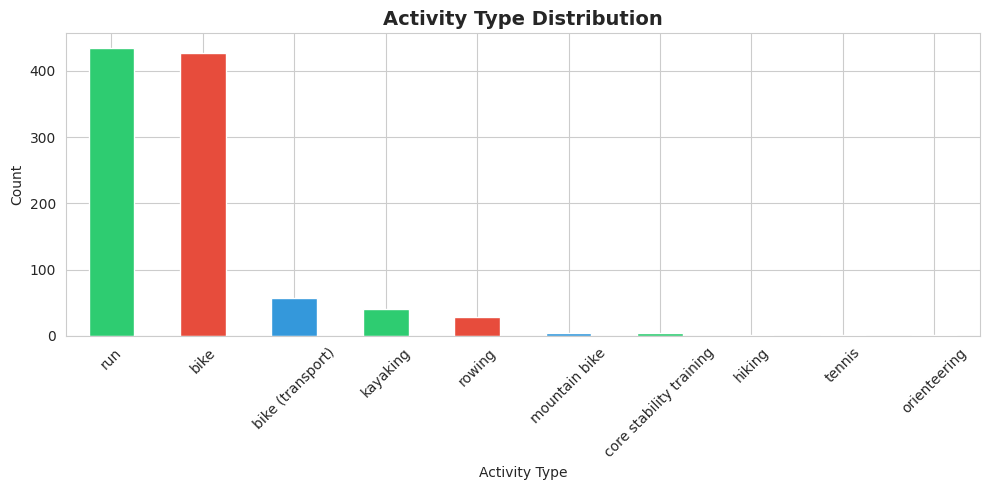

In [3]:
# Check sport distribution
sports = [w['sport'] for w in workouts]
sport_counts = pd.Series(sports).value_counts()

print("Sport Distribution:")
print(sport_counts)
print(f"\nTotal workouts: {len(workouts)}")

# Visualize
plt.figure(figsize=(10, 5))
sport_counts.plot(kind='bar', color=['#2ecc71', '#e74c3c', '#3498db'])
plt.title('Activity Type Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Activity Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Create Labels

- **Label 0 (Genuine)**: Activities labeled as "run"
- **Label 1 (Fraud)**: Activities labeled as "bike" or "bike (transport)"

In [4]:
def create_binary_labels(workouts):
    """Create binary labels: 0=run (genuine), 1=bike/other (fraud)."""
    labels = []
    for w in workouts:
        sport = w['sport'].lower()
        if 'run' in sport:
            labels.append(0)  # Genuine
        else:
            labels.append(1)  # Fraud (bike, etc.)
    return np.array(labels)

labels = create_binary_labels(workouts)

print(f"Genuine runs: {np.sum(labels == 0)}")
print(f"Fraudulent (bike): {np.sum(labels == 1)}")
print(f"\nClass balance: {np.sum(labels == 0) / len(labels) * 100:.1f}% runs")

Genuine runs: 435
Fraudulent (bike): 565

Class balance: 43.5% runs


## 4. Extract Features

For each workout, we'll compute simple statistical features:
- Speed statistics (mean, std, max)
- Heart rate statistics
- Elevation change
- Heart rate / speed correlation

In [5]:
def extract_features(workout):
    """Extract statistical features from a single workout."""
    features = {}
    
    # Speed features - handle missing data and missing keys
    if 'speed' in workout and workout['speed'] is not None:
        speed = np.array(workout['speed'], dtype=float)
        speed = speed[~np.isnan(speed)]  # Remove NaN values
        
        if len(speed) > 0:
            features['speed_mean'] = np.mean(speed)
            features['speed_std'] = np.std(speed)
            features['speed_max'] = np.max(speed)
            features['speed_min'] = np.min(speed)
        else:
            features['speed_mean'] = 0
            features['speed_std'] = 0
            features['speed_max'] = 0
            features['speed_min'] = 0
    else:
        features['speed_mean'] = 0
        features['speed_std'] = 0
        features['speed_max'] = 0
        features['speed_min'] = 0
    
    # Heart rate features - handle missing data and missing keys
    if 'heart_rate' in workout and workout['heart_rate'] is not None:
        hr = np.array(workout['heart_rate'], dtype=float)
        hr = hr[~np.isnan(hr)]  # Remove NaN values
        
        if len(hr) > 0:
            features['hr_mean'] = np.mean(hr)
            features['hr_std'] = np.std(hr)
            features['hr_max'] = np.max(hr)
            features['hr_min'] = np.min(hr)
        else:
            features['hr_mean'] = 0
            features['hr_std'] = 0
            features['hr_max'] = 0
            features['hr_min'] = 0
    else:
        features['hr_mean'] = 0
        features['hr_std'] = 0
        features['hr_max'] = 0
        features['hr_min'] = 0
    
    # Altitude features - handle missing data and missing keys
    if 'altitude' in workout and workout['altitude'] is not None:
        altitude = np.array(workout['altitude'], dtype=float)
        altitude = altitude[~np.isnan(altitude)]  # Remove NaN values
        
        if len(altitude) > 0:
            features['altitude_range'] = np.max(altitude) - np.min(altitude)
            features['altitude_std'] = np.std(altitude)
        else:
            features['altitude_range'] = 0
            features['altitude_std'] = 0
    else:
        features['altitude_range'] = 0
        features['altitude_std'] = 0
    
    # Heart rate vs speed correlation (key fraud indicator!)
    # Need to align valid data points for both speed and hr
    if ('speed' in workout and workout['speed'] is not None and 
        'heart_rate' in workout and workout['heart_rate'] is not None):
        
        speed_raw = np.array(workout['speed'], dtype=float)
        hr_raw = np.array(workout['heart_rate'], dtype=float)
        
        # Only use data points where both speed and hr are valid
        valid_mask = ~(np.isnan(speed_raw) | np.isnan(hr_raw))
        speed_valid = speed_raw[valid_mask]
        hr_valid = hr_raw[valid_mask]
        
        if len(speed_valid) > 1 and len(hr_valid) > 1 and np.std(speed_valid) > 0 and np.std(hr_valid) > 0:
            corr = np.corrcoef(speed_valid, hr_valid)[0, 1]
            features['hr_speed_corr'] = corr if not np.isnan(corr) else 0
        else:
            features['hr_speed_corr'] = 0
    else:
        features['hr_speed_corr'] = 0
    
    # Variability ratio (runners vary more than bikes)
    features['speed_variability'] = features['speed_std'] / (features['speed_mean'] + 1e-6)
    
    return features

# Extract features for all workouts
print("Extracting features...")
feature_list = [extract_features(w) for w in workouts]
df_features = pd.DataFrame(feature_list)
df_features['label'] = labels
df_features['sport'] = [w['sport'] for w in workouts]

print(f"Feature matrix shape: {df_features.shape}")
print("\nFirst few rows:")
df_features.head()

Extracting features...
Feature matrix shape: (1000, 14)

First few rows:


,speed_mean,speed_std,speed_max,speed_min,hr_mean,hr_std,hr_max,hr_min,altitude_range,altitude_std,hr_speed_corr,speed_variability,label,sport
0,26.162158,8.205578,57.4596,3.8592,152.650,10.229736,177.0,100.0,59.6,13.475900,-0.301684,0.313643,1,bike
1,27.218369,8.174864,54.7704,8.0820,147.710,10.970046,174.0,100.0,50.6,10.376062,-0.308628,0.300344,1,bike
2,26.050774,7.873346,59.2092,0.0000,140.554,11.319500,168.0,99.0,60.6,13.217515,-0.273782,0.302231,1,bike
3,26.877838,7.911340,57.9852,4.3272,147.020,11.414885,178.0,99.0,51.6,11.417463,-0.294671,0.294344,1,bike
4,0.000000,0.000000,0.0000,0.0000,167.154,10.414523,183.0,110.0,28.0,8.383674,0.000000,0.000000,1,bike (transport)


In [6]:
# Check for data quality issues
print("Checking for NaN/Inf values in features...")
print("\nNaN counts per feature:")
print(df_features[['speed_mean', 'speed_std', 'hr_mean', 'hr_std', 'hr_speed_corr', 'speed_variability']].isna().sum())
print("\nInf counts per feature:")
print(np.isinf(df_features[['speed_mean', 'speed_std', 'hr_mean', 'hr_std', 'hr_speed_corr', 'speed_variability']]).sum())
print("\nFeature value ranges:")
print(df_features[['speed_mean', 'speed_std', 'hr_mean', 'hr_std', 'hr_speed_corr', 'speed_variability']].describe())

Checking for NaN/Inf values in features...

NaN counts per feature:
speed_mean           0
speed_std            0
hr_mean              0
hr_std               0
hr_speed_corr        0
speed_variability    0
dtype: int64

Inf counts per feature:
speed_mean           0
speed_std            0
hr_mean              0
hr_std               0
hr_speed_corr        0
speed_variability    0
dtype: int64

Feature value ranges:
        speed_mean    speed_std      hr_mean       hr_std  hr_speed_corr  \
count  1000.000000  1000.000000  1000.000000  1000.000000    1000.000000   
mean      3.286713     0.906968   134.831206    12.158496       0.032363   
std       7.825868     2.429378    17.884036     5.227908       0.150871   
min       0.000000     0.000000    70.138000     0.000000      -1.000000   
25%       0.000000     0.000000   122.642778     8.461970       0.000000   
50%       0.000000     0.000000   138.112000    11.303743       0.000000   
75%       0.000000     0.000000   147.265565    14

## 5. Visualize Feature Differences

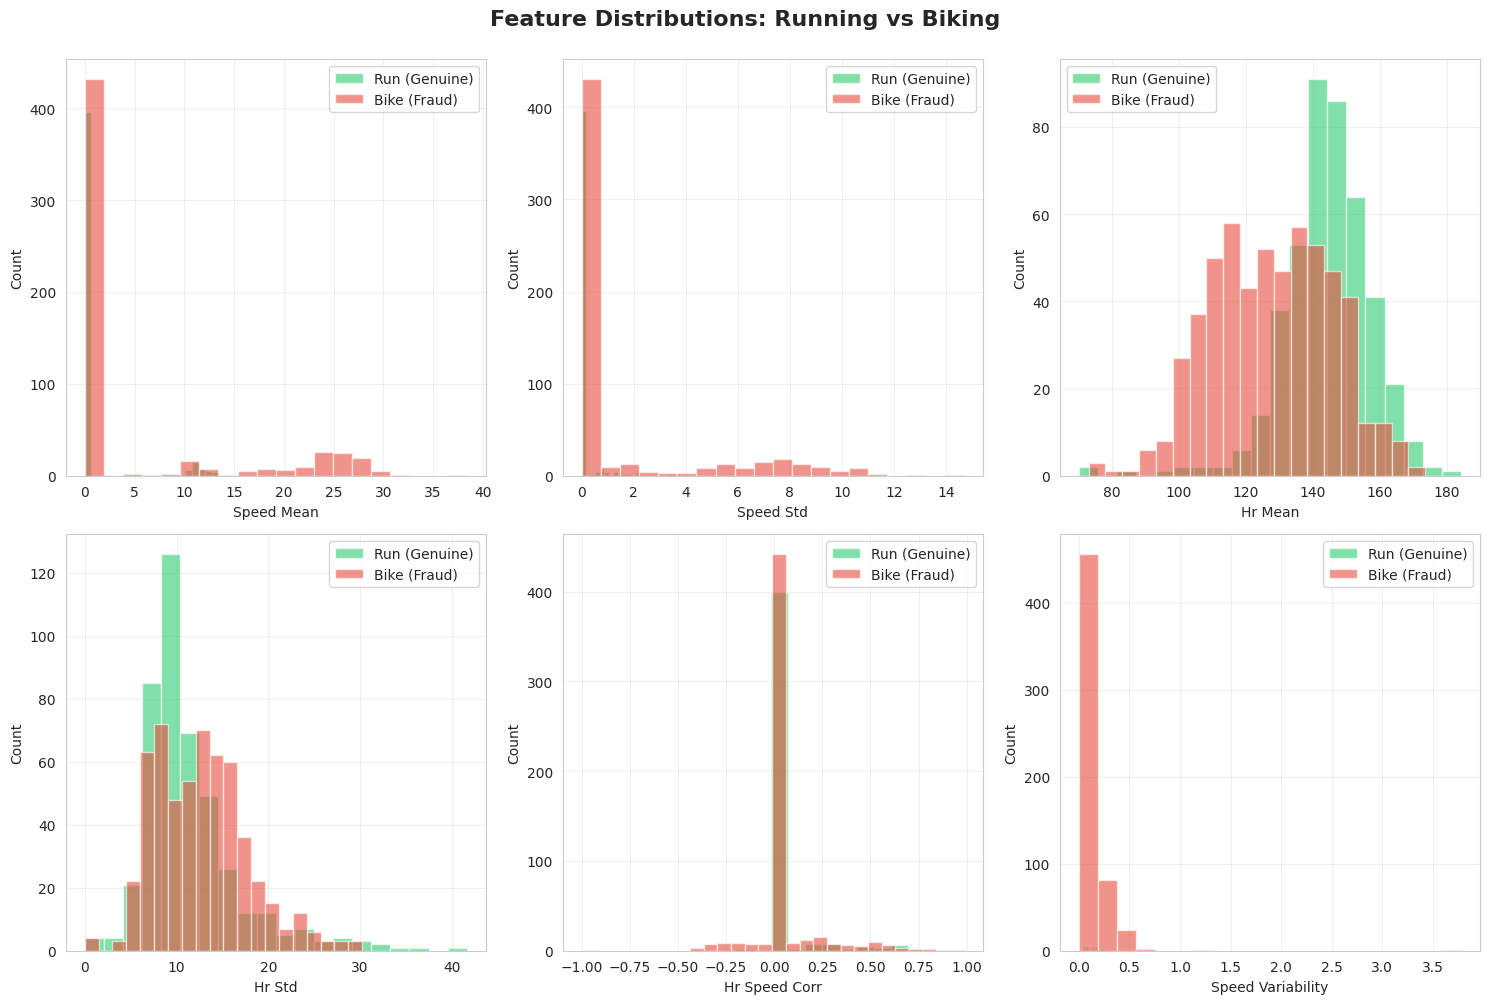

In [7]:
# Compare key features between genuine and fraud
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

features_to_plot = ['speed_mean', 'speed_std', 'hr_mean', 'hr_std', 'hr_speed_corr', 'speed_variability']
colors = ['#2ecc71', '#e74c3c']

for i, feature in enumerate(features_to_plot):
    for label, color, name in [(0, colors[0], 'Run (Genuine)'), (1, colors[1], 'Bike (Fraud)')]:
        data = df_features[df_features['label'] == label][feature]
        axes[i].hist(data, bins=20, alpha=0.6, label=name, color=color)
    
    axes[i].set_xlabel(feature.replace('_', ' ').title())
    axes[i].set_ylabel('Count')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.suptitle('Feature Distributions: Running vs Biking', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 6. Feature Statistics by Class

In [8]:
# Summary statistics
print("=" * 80)
print("Feature Statistics by Activity Type")
print("=" * 80)

for label, name in [(0, 'RUN (Genuine)'), (1, 'BIKE (Fraud)')]:
    print(f"\n{name}:")
    subset = df_features[df_features['label'] == label][features_to_plot]
    print(subset.describe().loc[['mean', 'std']].T)

Feature Statistics by Activity Type

RUN (Genuine):
                         mean        std
speed_mean           1.008860   3.256497
speed_std            0.124011   0.464427
hr_mean            144.056323  13.154908
hr_std              11.464805   5.393279
hr_speed_corr        0.027487   0.129588
speed_variability    0.010881   0.040067

BIKE (Fraud):
                         mean        std
speed_mean           5.040458   9.655936
speed_std            1.509776   3.074256
hr_mean            127.728682  17.809715
hr_std              12.692576   5.036964
hr_speed_corr        0.036117   0.165418
speed_variability    0.076516   0.210832


## 7. Visualize Sample Trajectories

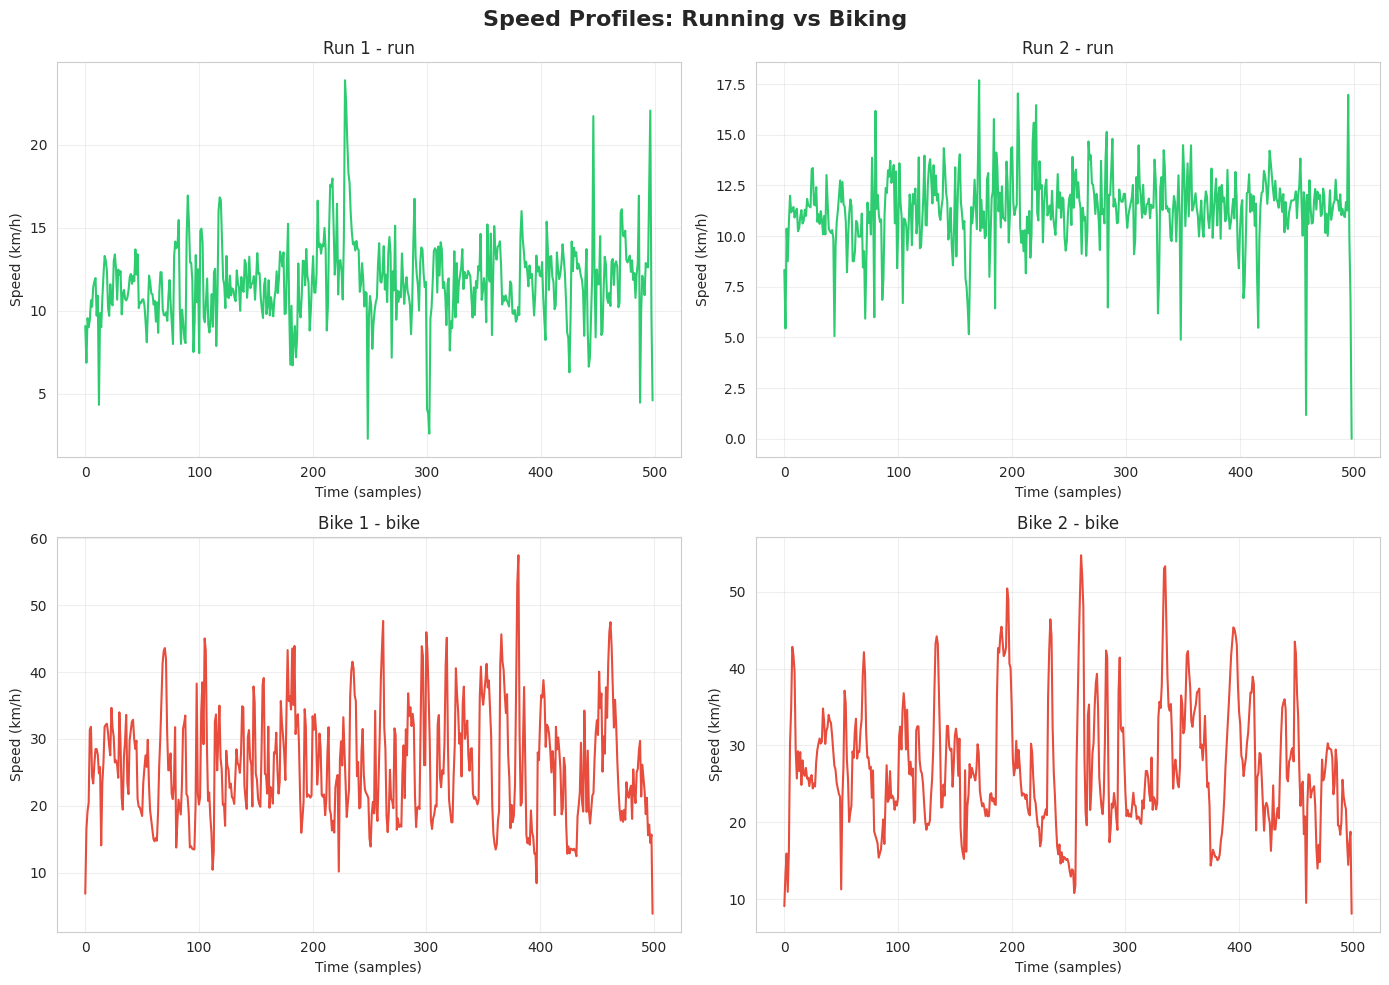

In [9]:
# Plot 2 running and 2 biking trajectories with valid speed data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Find sample workouts that have speed data
run_indices = [i for i, w in enumerate(workouts) if 'run' in w['sport'].lower() and 'speed' in w and len(w['speed']) > 0][:2]
bike_indices = [i for i, w in enumerate(workouts) if 'bike' in w['sport'].lower() and 'speed' in w and len(w['speed']) > 0][:2]

if len(run_indices) >= 2 and len(bike_indices) >= 2:
    for idx, (workout_idx, title_prefix) in enumerate([(run_indices[0], 'Run 1'), 
                                                         (run_indices[1], 'Run 2'),
                                                         (bike_indices[0], 'Bike 1'),
                                                         (bike_indices[1], 'Bike 2')]):
        ax = axes[idx // 2, idx % 2]
        
        workout = workouts[workout_idx]
        
        # Speed over time
        speed = np.array(workout['speed'])
        time = np.arange(len(speed))
        
        color = '#2ecc71' if 'run' in workout['sport'].lower() else '#e74c3c'
        ax.plot(time, speed, color=color, linewidth=1.5)
        ax.set_xlabel('Time (samples)')
        ax.set_ylabel('Speed (km/h)')
        ax.set_title(f"{title_prefix} - {workout['sport']}")
        ax.grid(alpha=0.3)
    
    plt.suptitle('Speed Profiles: Running vs Biking', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print(f"Not enough workouts with speed data. Found {len(run_indices)} runs and {len(bike_indices)} bikes.")


## 8. Heart Rate vs Speed Scatter Plot

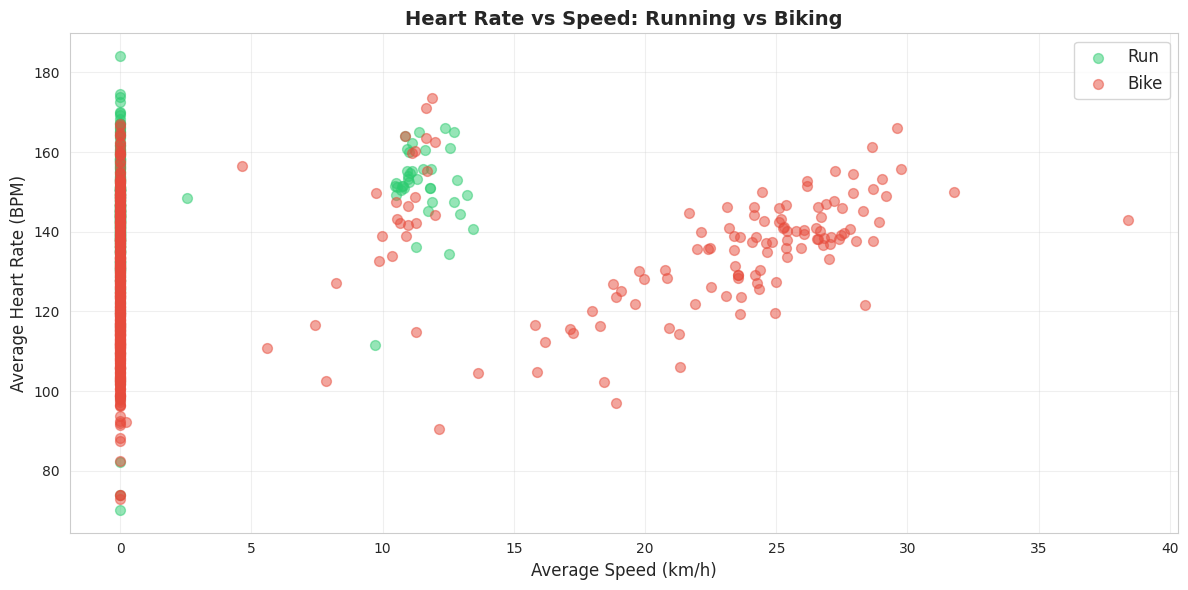

In [10]:
# Show HR vs Speed relationship
plt.figure(figsize=(12, 6))

for label, color, name in [(0, '#2ecc71', 'Run'), (1, '#e74c3c', 'Bike')]:
    mask = df_features['label'] == label
    plt.scatter(df_features[mask]['speed_mean'], 
                df_features[mask]['hr_mean'],
                alpha=0.5, s=50, c=color, label=name)

plt.xlabel('Average Speed (km/h)', fontsize=12)
plt.ylabel('Average Heart Rate (BPM)', fontsize=12)
plt.title('Heart Rate vs Speed: Running vs Biking', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Simple Baseline Model: Random Forest Classifier

Train a simple Random Forest on the statistical features to classify genuine vs fraudulent activities.

In [11]:
# Prepare data for modeling
X = df_features[features_to_plot].fillna(0).values
y = df_features['label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTrain class distribution: Run={np.sum(y_train==0)}, Bike={np.sum(y_train==1)}")
print(f"Test class distribution: Run={np.sum(y_test==0)}, Bike={np.sum(y_test==1)}")

Training set: 700 samples
Test set: 300 samples

Train class distribution: Run=305, Bike=395
Test class distribution: Run=130, Bike=170


In [12]:
# Train Random Forest
print("Training Random Forest Classifier...")
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# Evaluate
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"\nTrain Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

Training Random Forest Classifier...

Train Accuracy: 0.924
Test Accuracy: 0.843


## 10. Model Evaluation

In [13]:
# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred_test, target_names=['Run (Genuine)', 'Bike (Fraud)']))


CLASSIFICATION REPORT
               precision    recall  f1-score   support

Run (Genuine)       0.84      0.79      0.81       130
 Bike (Fraud)       0.85      0.88      0.86       170

     accuracy                           0.84       300
    macro avg       0.84      0.84      0.84       300
 weighted avg       0.84      0.84      0.84       300



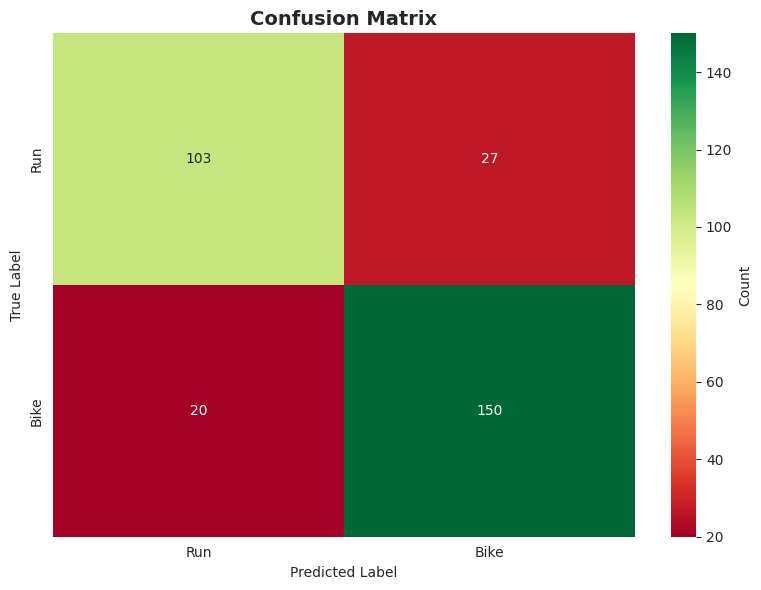

In [14]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', 
            xticklabels=['Run', 'Bike'], 
            yticklabels=['Run', 'Bike'],
            cbar_kws={'label': 'Count'})
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 11. Feature Importance

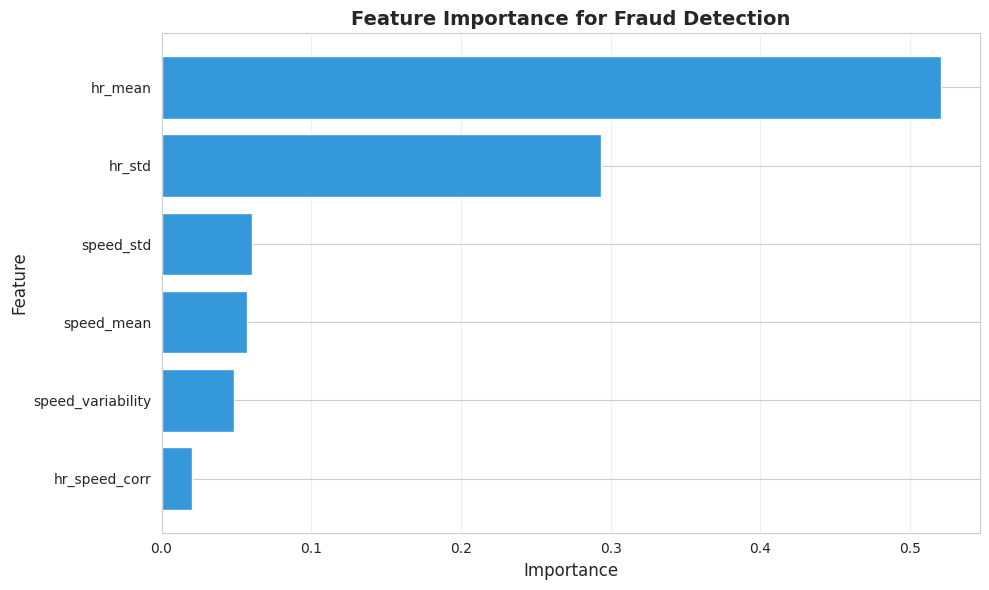


Feature Importance Ranking:
             feature  importance
2            hr_mean    0.520745
3             hr_std    0.293880
1          speed_std    0.060258
0         speed_mean    0.056967
5  speed_variability    0.048105
4      hr_speed_corr    0.020046


In [15]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': features_to_plot,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='#3498db')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance for Fraud Detection', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
print(feature_importance)

## 12. Summary & Next Steps

### Key Findings:
1. **Speed patterns differ**: Bikers have higher average speed and lower variability
2. **Heart rate correlation**: Strong indicator for fraud detection
3. **Simple baseline model**: Random Forest achieves good accuracy with basic features

### Next Steps for Deep Learning Project:
1. **LSTM/GRU model**: Use full time-series data (not just statistics)
2. **Multi-input architecture**: Combine speed, HR, and elevation sequences
3. **Attention mechanism**: Identify suspicious segments in trajectories
4. **Data augmentation**: Create synthetic fraud examples
5. **Expand dataset**: Use more samples from the full dataset

In [16]:
# Save feature data for future use
df_features.to_csv('features_sample.csv', index=False)
print("Features saved to 'features_sample.csv'")

Features saved to 'features_sample.csv'
